In [4]:
!pip install timm

In [5]:
#IMPORT ALL LIBRARIES
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

In [6]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

class CelebDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes


In [7]:
import zipfile
import os

# Define paths
zip_file_path = 'Dataset.zip'
extraction_path = 'dataset'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Open the zip file for reading
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents of the zip file
    zip_ref.extractall(extraction_path)

print(f"Datasets extracted to: {extraction_path}")

Datasets extracted to: dataset


In [11]:
dataset = CelebDataset(
    data_dir='dataset/train'
)

In [12]:
data_dir = 'dataset/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'Arnold_Schwarzenegger', 1: 'George_W_Bush', 2: 'Junichiro_Koizumi', 3: 'Tony_Blair', 4: 'Vladimir_Putin'}


TRANSFORMING


In [13]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = 'dataset/train'
dataset = CelebDataset(data_dir, transform)

In [14]:
for image, label in dataset:
    break

DATA LOADERS

In [15]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
for images, labels in dataloader:
    break
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [16]:
labels

tensor([1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 3, 1, 0, 1, 1, 3, 1,
        1, 1, 3, 2, 2, 4, 1, 3])

PYTORCH MODEL

In [17]:
class SimpleCelebClassifer(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCelebClassifer, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [18]:
model = SimpleCelebClassifer(num_classes=5)
print(str(model)[:500])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SimpleCelebClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [19]:
example_out = model(images)
example_out.shape

torch.Size([32, 5])

Starting Training Loop

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 5]) torch.Size([32])


Dataset

In [22]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = 'dataset/train'
valid_folder = 'dataset/valid'
test_folder = 'dataset/test'

train_dataset = CelebDataset(train_folder, transform=transform)
val_dataset = CelebDataset(valid_folder, transform=transform)
test_dataset = CelebDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Training Loop

In [23]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCelebClassifer(num_classes=5)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/26 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.4708608351873629, Validation loss: 0.057306162064725705


Training loop:   0%|          | 0/26 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.1435946926023021, Validation loss: 0.1533446230310382


Training loop:   0%|          | 0/26 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.06983851192575513, Validation loss: 0.02802771284668283


Training loop:   0%|          | 0/26 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.020573520282226983, Validation loss: 0.011430205445433262


Training loop:   0%|          | 0/26 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.02042191235743689, Validation loss: 0.044708251069215214


Plotting the Loss

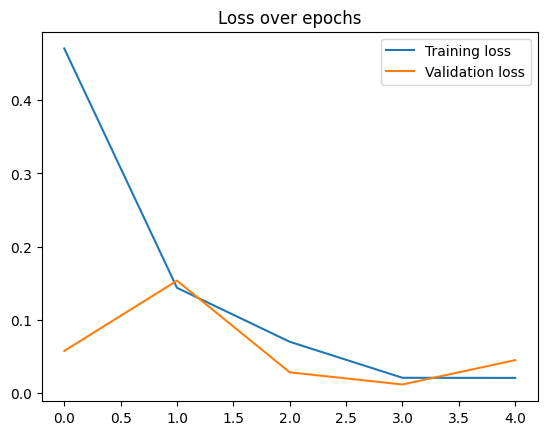

In [24]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

Evaluating the results

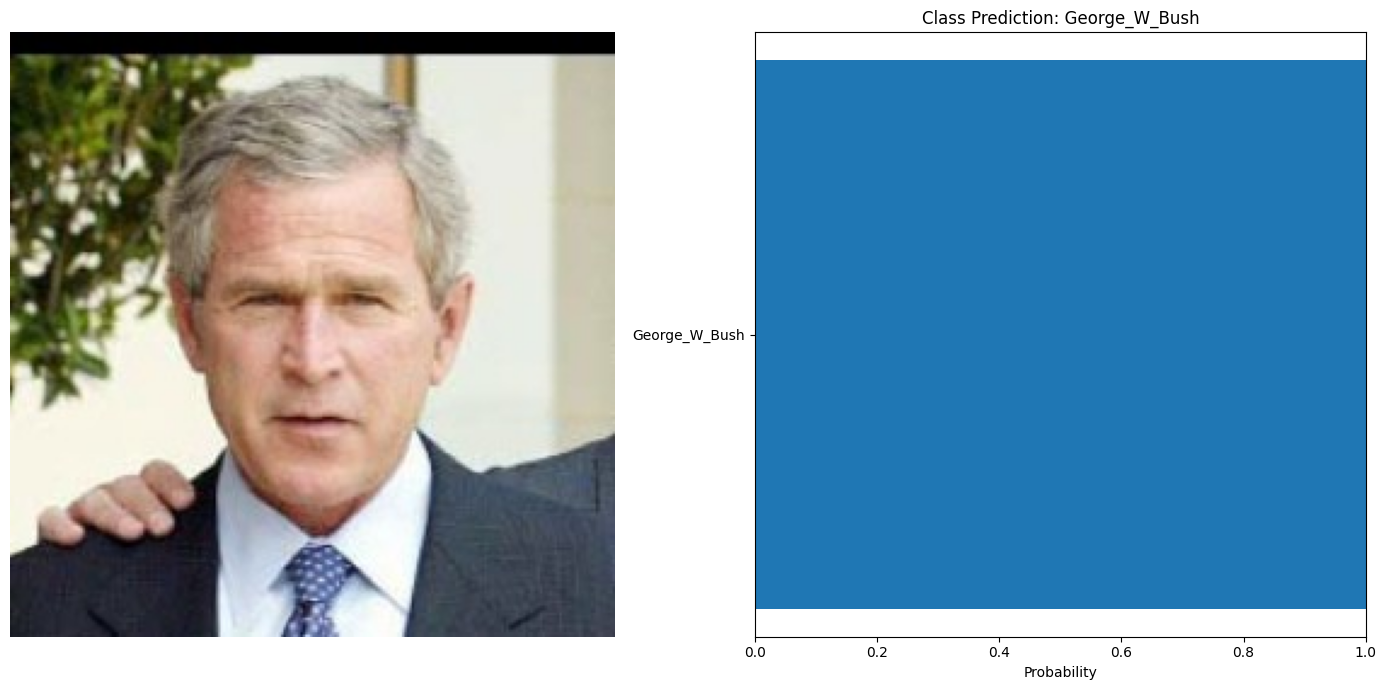

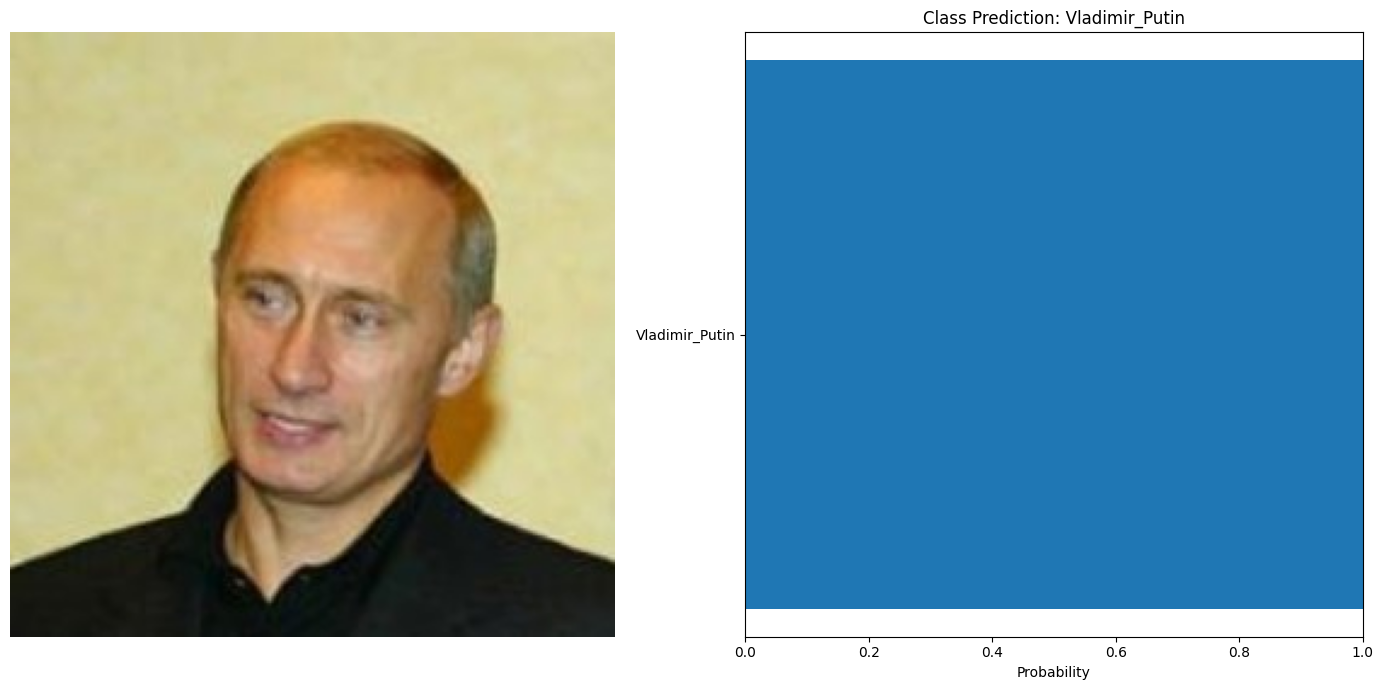

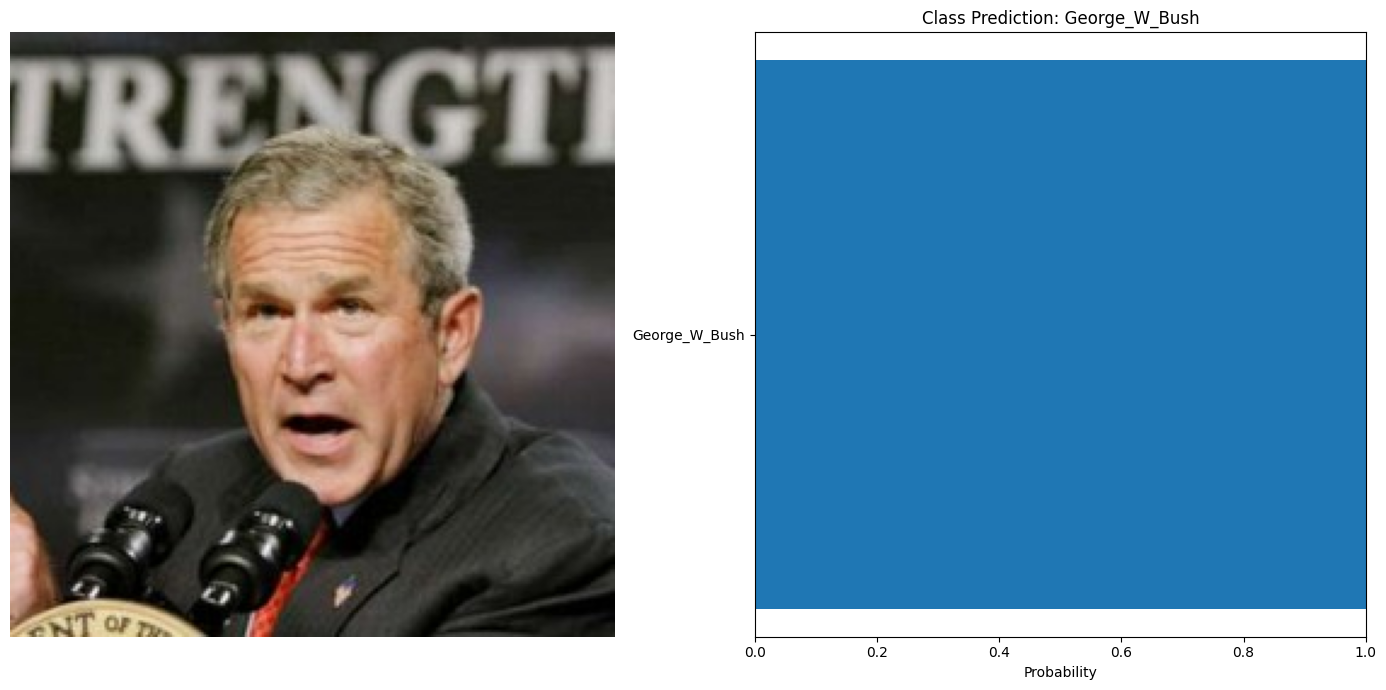

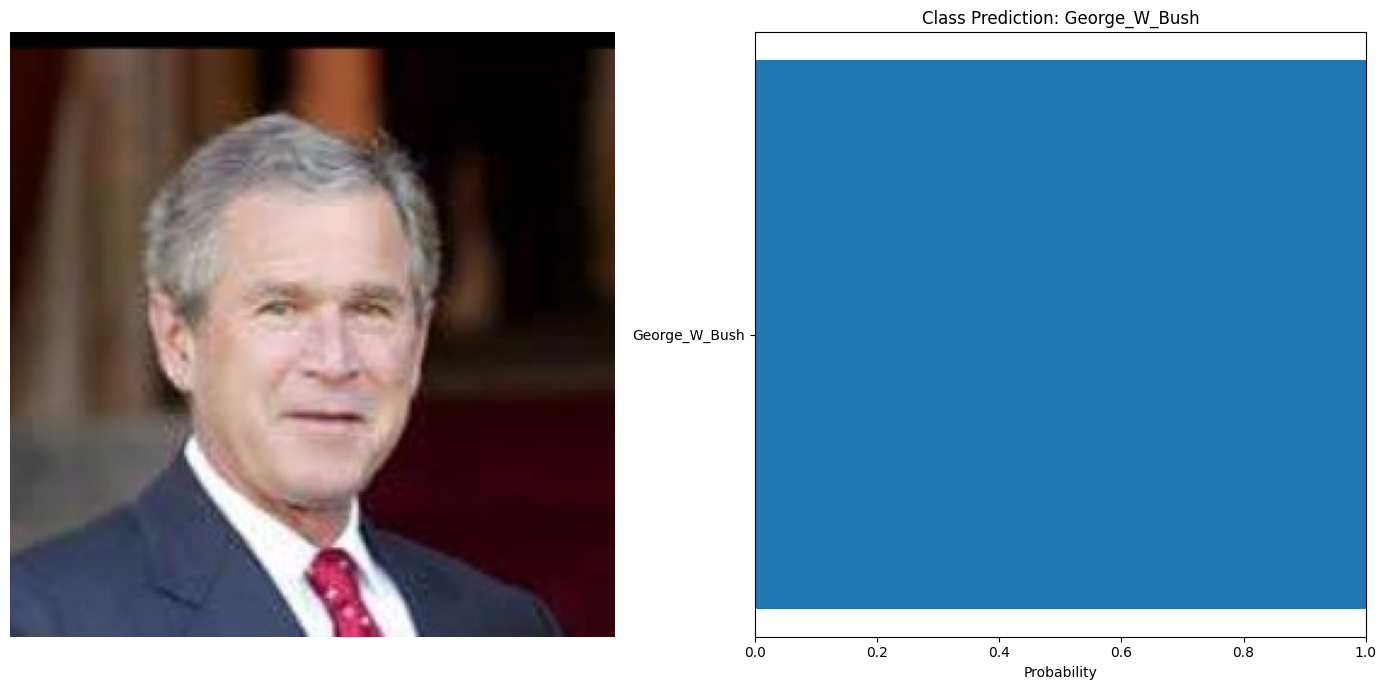

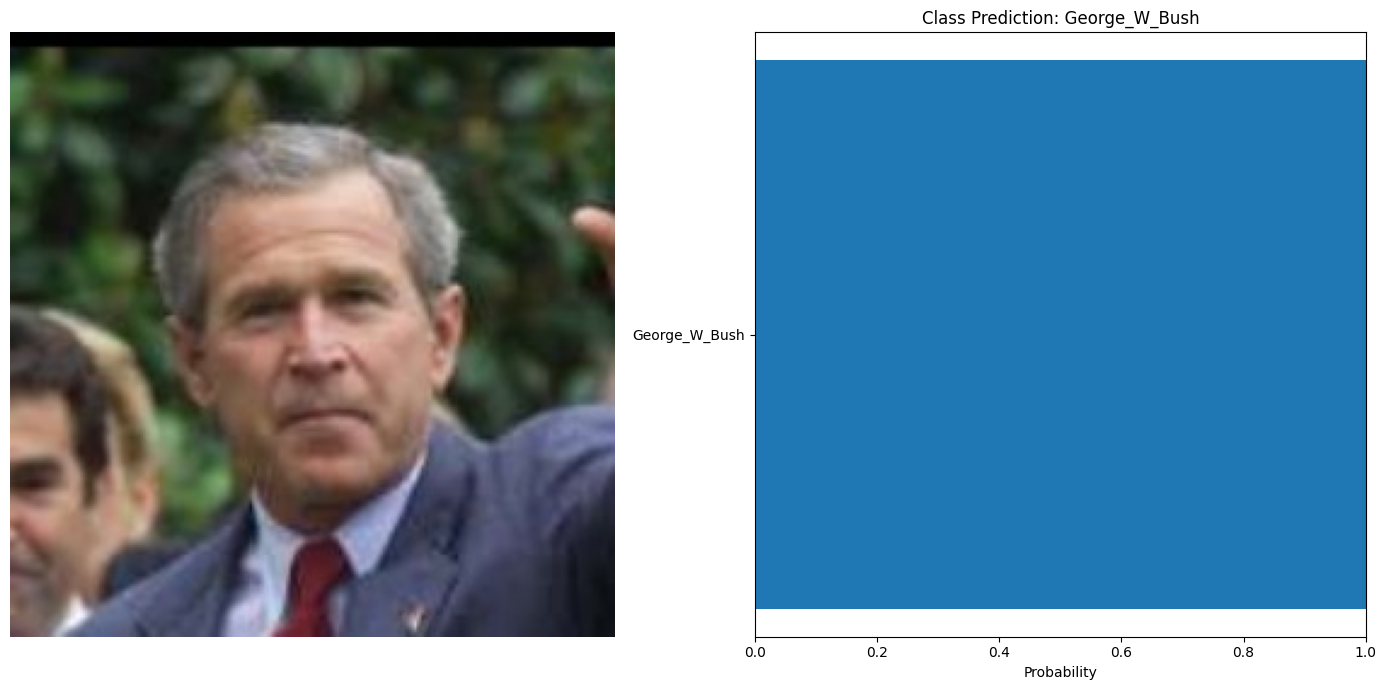

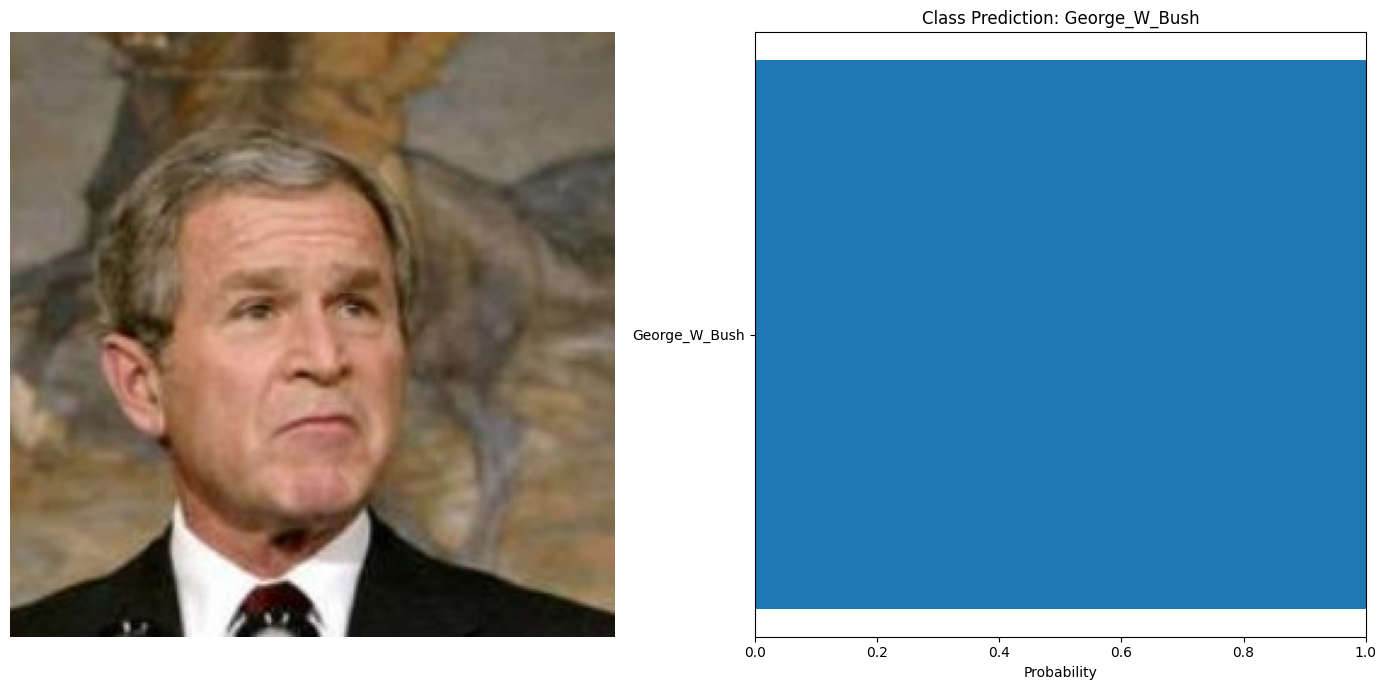

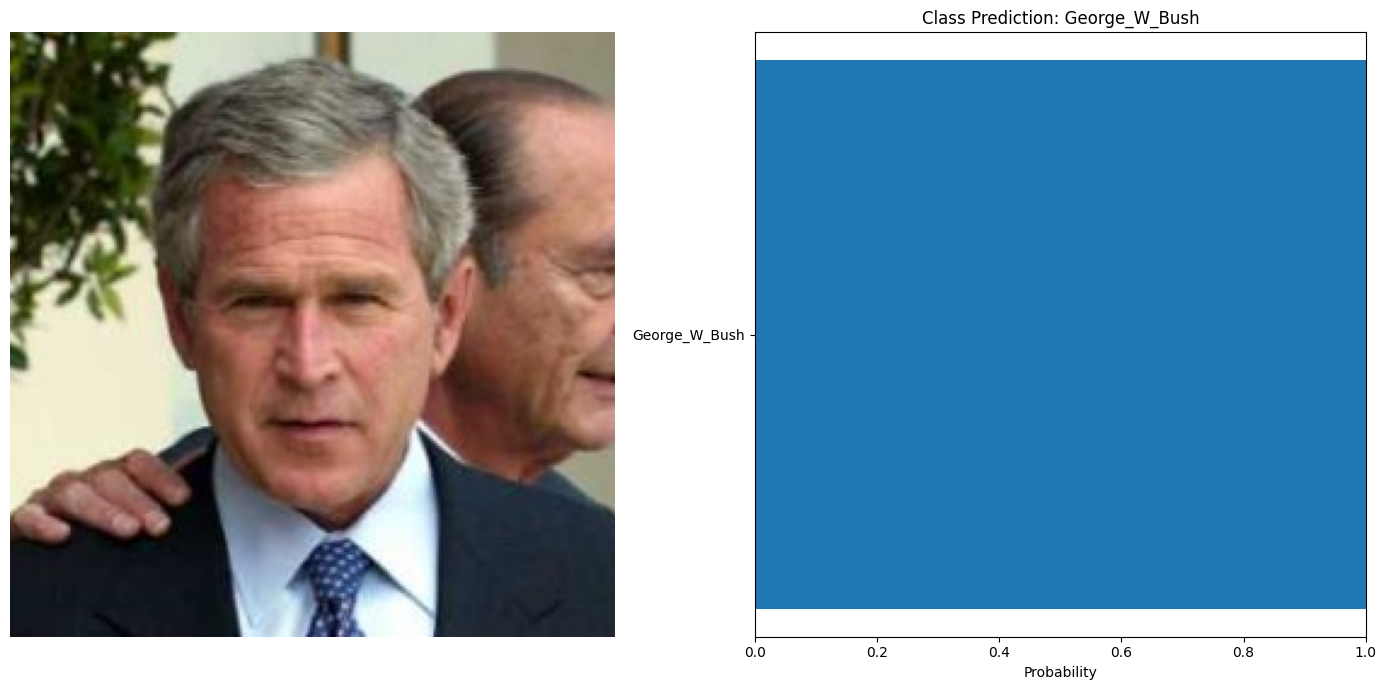

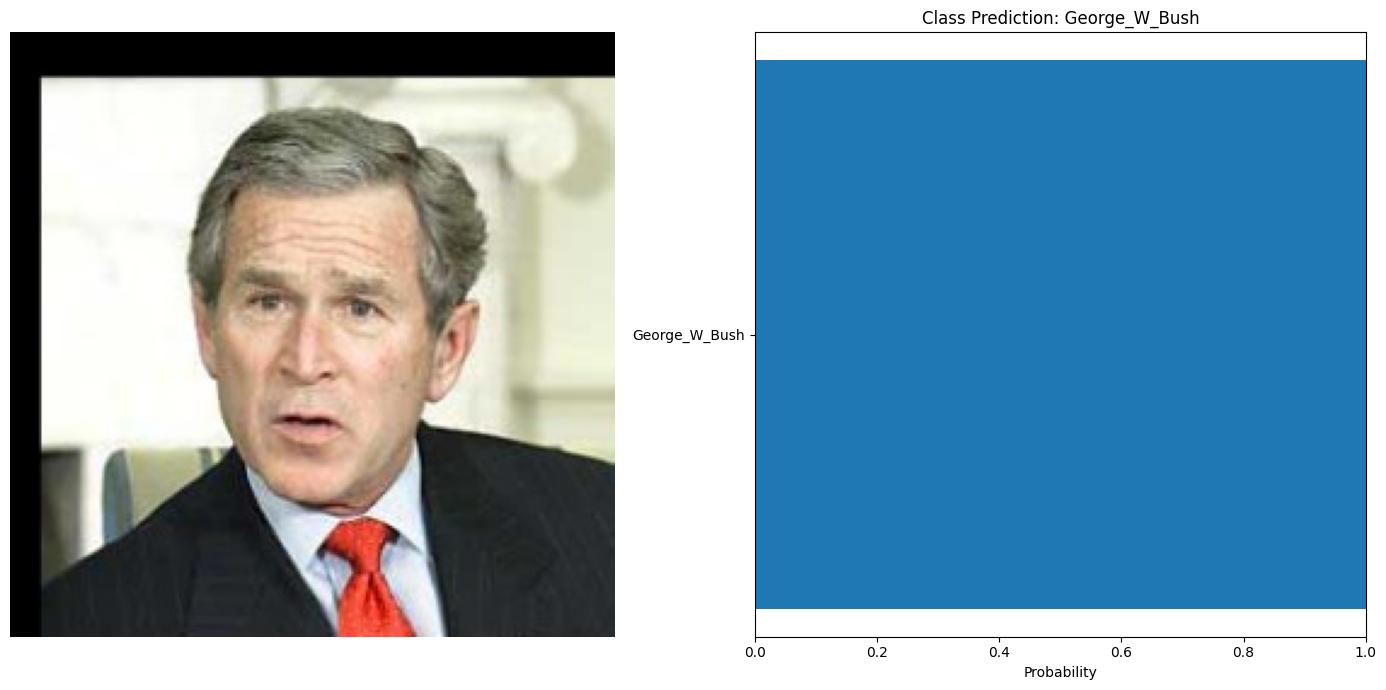

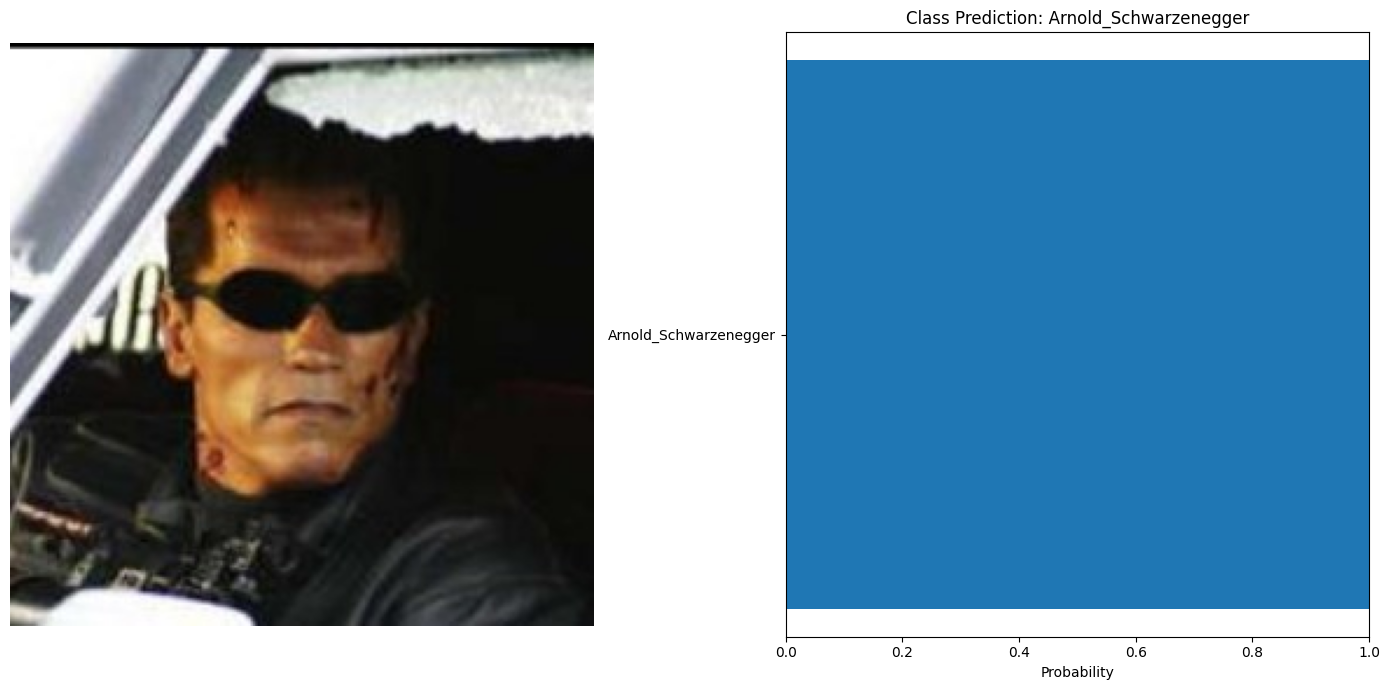

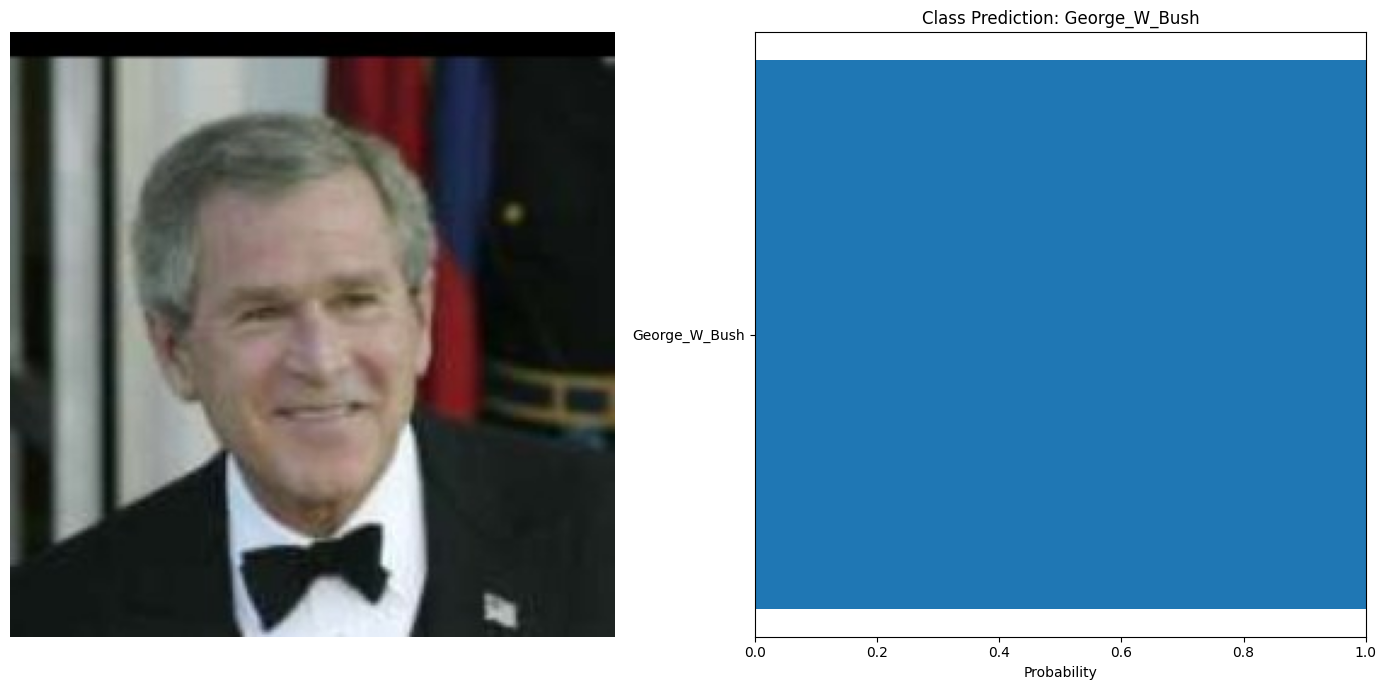

In [25]:
from PIL import Image

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)

        # Check if outputs is not None and has valid values
        if outputs is not None and torch.isfinite(outputs).all():
            probabilities, predicted_class = torch.max(outputs, 1)

            # Replace NaN values with zeros in probabilities
            probabilities[torch.isnan(probabilities)] = 0.0

            return probabilities.cpu().numpy().flatten(), predicted_class.item()
        else:
            # Return default values or handle the case appropriately
            return np.zeros(model.num_classes), -1  # Replace with appropriate values



# Visualization
def visualize_predictions(original_image, probabilities, predicted_class, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    if probabilities is not None and len(probabilities) > 0:
        class_name = class_names[predicted_class]
        axarr[1].barh([class_name], probabilities)
        axarr[1].set_xlabel("Probability")
        axarr[1].set_title("Class Prediction: {}".format(class_name))
        axarr[1].set_xlim(0, 1)
    else:
        axarr[1].set_xlabel("Probability")
        axarr[1].set_title("No valid predictions")
        axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

from glob import glob
test_images = glob('dataset/train/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities, predicted_class = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, predicted_class, class_names)